# Lecture 7.2: Moving Average Models and ARMA

<!--
## Outline

This week we'll look at a variety of topics in preparation for the full scale look at ARIMA time series models that we'll do in the next few weeks. Topics this week are MA models, partial autocorrelation, and notational conventions.
-->

## Objectives  

* Identify and interpret an MA(q) model
* Distinguish MA terms from an ACF
* Interpret a PACF
* Distinguish AR terms and MA terms from simultaneously exploring an ACF and PACF
* Recognize and write AR, MA, and ARMA polynomials

<!--
## References  

Some helpful references, arranged by increasing difficulty:  

* Hyndman & Athanasopoulos: “[Forecasting: principles and practice](https://www.otexts.org/fpp)”
* Enders: “Applied Econometric Time Series”
* Hamilton: “Time Series Analysis”
-->

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample

Populating the interactive namespace from numpy and matplotlib


## Moving Average Models (MA models)

Time series models known as ARMA models may include autoregressive terms and/or moving average terms.  Yesterday, we learned an autoregressive term in a time series model for the variable $x_t$  is a lagged value of $x_t$.  For instance, a lag 1 autoregressive term is $x_{t-1}$ (multiplied by a coefficient).  This lesson defines moving average terms.

<!-- https://www.otexts.org/fpp/8/4 -->
Rather than use past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.
<!-- https://onlinecourses.science.psu.edu/stat510/node/48 -->
> Let $\epsilon_t\overset{iid}{\sim}N(0,\sigma^2_w)$ meaning that the $\epsilon_t$ are identically, independently distributed, each with a normal distribution having mean 0 and the same variance. 
> 
> The **1<sup>st</sup> order moving average model**, denoted by MA(1) is
> 
$$x_t = \mu + \epsilon_t +\theta_1\epsilon_{t-1}$$
> 
> The **2<sup>nd</sup> order moving average model**, denoted by MA(2) is
> 
$$x_t = \mu + \epsilon_t +\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}$$
> 
> The **q<sup>th</sup> order moving average model**, denoted by MA(q) is
>
$$x_t = \mu + \epsilon_t +\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\dots + \theta_q\epsilon_{t-q}$$

Of course, we do not _observe_ the values of $\epsilon_t$, so it is not really regression in the usual sense.

### Theoretical Properties of a Time Series with an MA(1) Model

* Mean is $E(x_t) = \mu$
* Variance is $Var(x_t) = \sigma_\epsilon^2(1 + \theta_1^2)$
* Autocorrelation function (ACF) is $$\rho_1 = \frac{\theta_1}{1+\theta^2_1}, \text{ and } \rho_h = 0 \text{ for } h \ge 2$$  

Note that the _only nonzero value in the theoretical ACF is for lag 1_.  All other autocorrelations are 0.  Thus a sample ACF with a significant autocorrelation only at lag 1 is an indicator of a possible MA(1) model.

In [2]:
def ma_acov(maparams, nobs):
    from statsmodels.tsa.filters.filtertools import convolution_filter
    ma = r_[1, maparams]  # add zero-lag
    q = len(maparams)
    acovf = convolution_filter(r_[ma, [0] * q], ma[::-1], 1)[q:]
    return r_[acovf, [0] * (nobs - q)]

def ma_acf(maparams, nobs):
    acovf = ma_acov(maparams, nobs)
    return acovf/acovf[0]

### Example 1

Suppose that an MA(1) model is $x_t=10+\epsilon_t+.7\epsilon_{t-1}$ where $\epsilon_t \overset{iid}{\sim} N(0,1)$. Thus the coefficient $\theta_1= 0.7$.  The theoretical ACF is given by $$\rho_1 = \frac{0.7}{1+0.7^2} = 0.4698, \text{ and } \rho_h = 0 \text{ for all lags } h \ge 2$$ A plot of this ACF follows.

In [3]:
ma1params = [.7]
acfma1 = ma_acf(ma1params, 10)

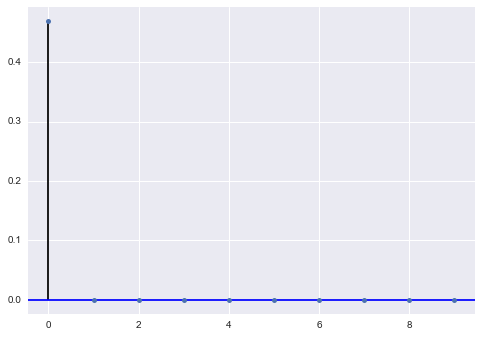

In [4]:
def plot_theoretical_acf(acf):
    lags = len(acf) - 1
    axhline(); margins(.05);
    vlines(range(lags), zeros(lags), acf[1:]); 
    plot(acf[1:], marker='o', markersize=5, linestyle='None');

plot_theoretical_acf(acfma1)

The plot just shown is the theoretical ACF for an MA(1) with $\theta_1=0.7$. In practice, a sample won’t usually provide such a clear pattern. Using `statsmodels`, we simulate n = 150 sample values using the model $x_t=10+\epsilon_t+.7\epsilon_{t-1}$ where $\epsilon_t \overset{iid}{\sim} N(0,1)$. 

In [5]:
random.seed(9)
ar0params = array([])  # arma_generate_sample requires both AR and MA parameters
ar0 = r_[1, -ar0params] # add zero-lag and negate
ma1 = r_[1, ma1params]  # add zero-lag
xc = arma_generate_sample(ar0, ma1, 150)  # Simulates n = 150 values from MA(1)
x1 = xc + 10  # adds 10 to make mean = 10. Simulation defaults to mean = 0.

For this simulation, a time series plot of the sample data follows.  We can’t tell much from this plot.

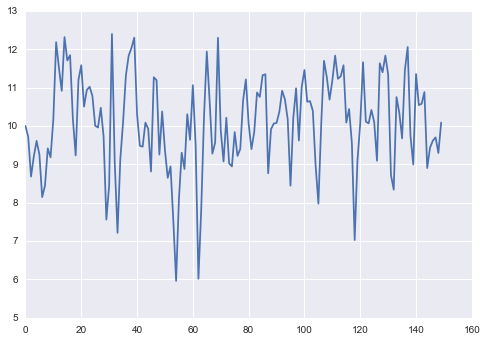

In [6]:
plot(x1);

The sample ACF for the simulated data follows.  We see a "spike" at lag 1 followed by generally non-significant values for lags past 1.  Note that the sample ACF does not match the theoretical pattern of the underlying MA(1), which is that all autocorrelations for lags past 1 will be 0.  A different sample would have a slightly different sample ACF shown below, but would likely have the same broad features.

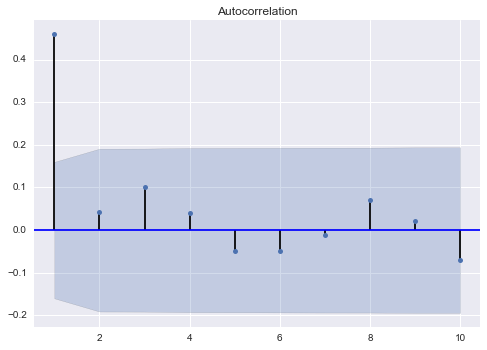

In [7]:
plot_acf(x1, lags=10, zero=False);

### Theroretical Properties of a Time Series with an MA(2) Model

For the MA(2) model, theoretical properties are the following:

* Mean is $E(x_t)=\mu$
* Variance is $Var(x_t)=\sigma_\epsilon^2(1+\theta_1^2\theta_2^2)$
* Autocorrelation function (ACF) is $$\rho_1 = \frac{\theta_1+\theta_1\theta_2}{1+\theta^2_1 +\theta^2_2}, \text{ } \rho_2 = \frac{\theta_2}{1+\theta^2_1 +\theta^2_2}, \text{ and } \rho_h = 0 \text{ for } h \ge 3$$  

Note that the only nonzero values in the theoretical ACF are for lags 1 and 2.  Autocorrelations for higher lags are 0.  So, a sample ACF with significant autocorrelations at lags 1 and 2, but non-significant autocorrelations for higher lags indicates a possible MA(2) model.

### Example 2

Consider the MA(2) model $x_t=10+\epsilon_t+.5\epsilon_{t-1} + .3\epsilon_{t-2}$, where $\epsilon_t \overset{iid}{\sim} N(0,1)$.  The coefficients are $\theta_1=0.5$ and $\theta_2=0.3$. Because this is an MA(2), the theoretical ACF will have nonzero values only at lags 1 and 2.

Values of the two nonzero autocorrelations are $$\rho_1 = \frac{0.5+0.5 \times 0.3}{1+0.5^2 +0.3^2} = 0.4851 \text{ and } \rho_2 = \frac{0.3}{1+0.5^2 +0.3^2}= 0.2239$$

A plot of the theoretical ACF follows.

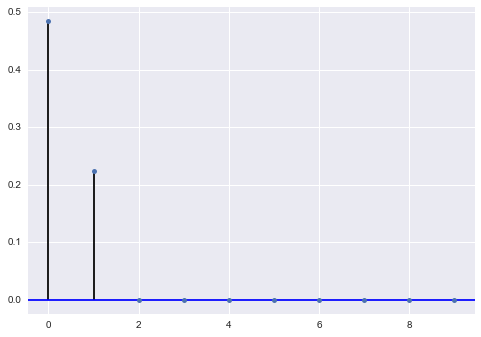

In [8]:
ma2params = array([.5, .3])
acfma2 = ma_acf(ma2params, 10)
plot_theoretical_acf(acfma2)

> As nearly always is the case, sample data won’t behave quite so perfectly as theory.  We simulate n = 150 sample values for the model $x_t=10+\epsilon_t+.5\epsilon_{t-1} + .3\epsilon_{t-2}$, where $\epsilon_t \overset{iid}{\sim} N(0,1)$.  The time series plot of the data follows.  As with the time series plot for the MA(1) sample data, you can’t tell much from it.

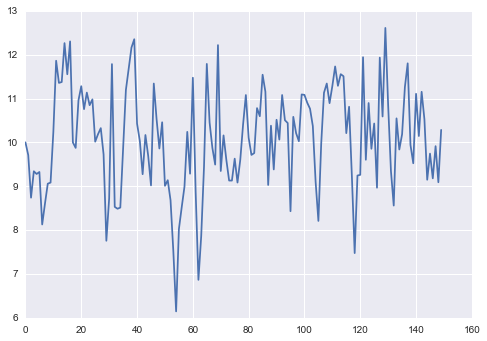

In [9]:
random.seed(9)
ma2 = r_[1, ma2params]  # add zero-lag
x2 = arma_generate_sample(ar0, ma2, 150) + 10
plot(x2);

> The sample ACF for the simulated data follows.  The pattern is typical for situations where an MA(2) model may be useful.  There are two statistically significant "spikes" at lags 1 and 2 followed by non-significant values for other lags.  Note that due to sampling error, the sample ACF did not match the theoretical pattern exactly.

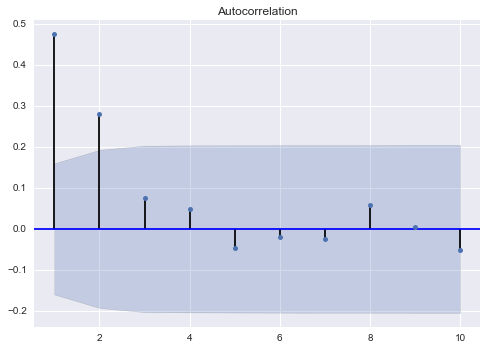

In [10]:
plot_acf(x2, lags=10, zero=False);

<!--
### ACF for General MA(q) Models

A property of MA(q) models in general is that there are nonzero autocorrelations for the first q lags and autocorrelations = 0 for all lags > q.

#### Non-uniqueness of connection between values of $\theta_1$ and $\rho_1$ in MA(1) Model.
-->

## Partial Autocorrelation Function (PACF)

### Partial Correlation

First a review of partial correlation. Though we did not cover this explicitly last week, we can see how it relates to the problem of multiple linear regression:
> 
* In general, a partial correlation is a conditional correlation.
* It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.
* For instance, consider a regression context in which $y=$ response variable and $x_1$, $x_2$, and $x_3$ are predictor variables. The partial correlation between $y$ and $x_3$ is the correlation between the variables determined taking into account how both $y$ and $x_3$ are related to $x_1$ and $x_2$.
* In regression, this partial correlation could be found by correlating the residuals from two different regressions: 
    1. Regression in which we predict $y$ from $x_1$ and $x_2$,
    2. regression in which we predict $x_3$ from $x_1$ and $x_2$.  
Basically, we correlate the "parts" of $y$ and $x_3$ that are not predicted by $x_1$ and $x_2$.
* More formally, we can define the partial correlation just described as $$\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$$
* Note that this is also how the parameters of a regression model are interpreted.  Think about the difference between interpreting the regression models: $$y = \beta_0 + \beta_1x^2  \text{ and } y = \beta_0+\beta_1x+\beta_2x^2$$  
In the first model, $\beta_1$ can be interpreted as the linear dependency between $x^2$ and $y$. In the second model, $\beta_2$ would be interpreted as the linear dependency between $x^2$ and $y$ WITH the dependency between $x$ and $y$ already accounted for.

Moving on to time series:
> 
* For a time series, the partial autocorrelation between $x_t$ and $x_{t-h}$ is defined as the conditional correlation between $x_t$ and $x_{t-h}$, conditional on $x_{t-h+1},\ldots,x_{t-1},$ the set of observations that come between the time points $t$ and $t−h$.
* The 1<sup>st</sup> order partial autocorrelation will be defined to equal the 1st order autocorrelation.
* The 2<sup>nd</sup> order (lag) partial autocorrelation is $$\frac{\text{Covariance}(x_t, x_{t-2}| x_{t-1})}{\sqrt{\text{Variance}(x_t|x_{t-1})\text{Variance}(x_{t-2}|x_{t-1})}}$$
This is the correlation between values two time periods apart conditional on knowledge of the value in between. (By the way, the two variances in the denominator will equal each other in a stationary series.)
* The 3<sup>rd</sup> order (lag) partial autocorrelation is $$\frac{\text{Covariance}(x_t, x_{t-3}| x_{t-1}, x_{t-2})}{\sqrt{\text{Variance}(x_t|x_{t-1},x_{t-2})\text{Variance}(x_{t-3}|x_{t-1},x_{t-2})}}$$
And, so on, for any lag.
> 
Typically, matrix manipulations having to do with the covariance matrix of a multivariate distribution are used to determine estimates of the partial autocorrelations.

In [11]:
def ma_pacf(maparams, nobs):
    from scipy import linalg
    apacf = np.zeros(nobs)
    acov = ma_acov(maparams, nobs)
    apacf[0] = 1.
    for k in range(2, nobs+1):
        r = acov[:k]
        apacf[k-1] = linalg.solve(linalg.toeplitz(r[:-1]), r[1:])[-1]
    return apacf

### Some Useful Facts About PACF and ACF Patterns
#### Identification of an AR model is often best done with the PACF.
>  
* For an AR model, the theoretical PACF "shuts off" past the order of the model.  The phrase "shuts off" means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the "order of the model" we mean the most extreme lag of $x$ that is used as a predictor.

### Example 3

Yesterday we identified an AR(1) model for a time series of Google stock data. Following is the sample PACF for this series.  Note that the first lag value is statistically significant, whereas partial autocorrelations for all other lags are not statistically significant.  This suggests a possible AR(1) model for these data.

In [12]:
import pandas_datareader.data as web
start = datetime.datetime(2005, 2, 7)
end = datetime.datetime(2005, 7, 7)
goog = web.DataReader("GOOG", 'yahoo', start, end)

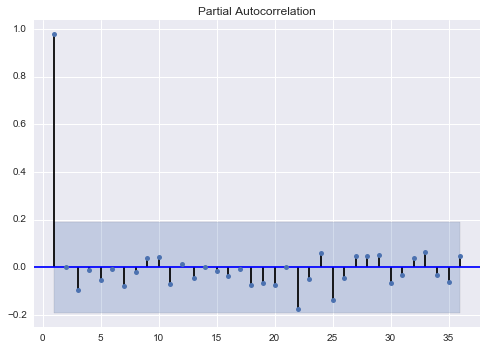

In [13]:
plot_pacf(goog.Close, lags=36, zero=False);

#### Identification of an MA model is often best done with the ACF rather than the PACF.
> 
* For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

**Example 1**, above, included the following sample ACF for a simulated MA(1) series.  Note that the first lag autocorrelation is statistically significant whereas all subsequent autocorrelations are not.  This suggests a possible MA(1) model for the data.

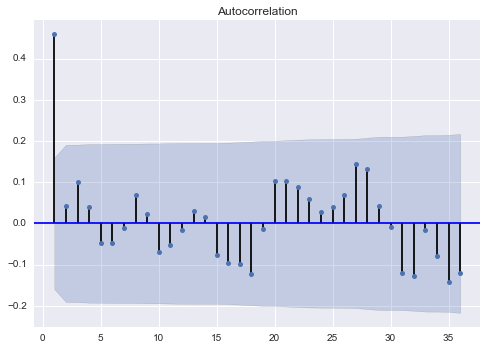

In [14]:
plot_acf(x1, lags=36, zero=False);

The underlying model used for the MA(1) simulation was $x_t=10+\epsilon_t+.7\epsilon_{t-1}$.  Following is the theoretical PACF (partial autocorrelation) for that model.  Note that the pattern gradually tapers to 0.

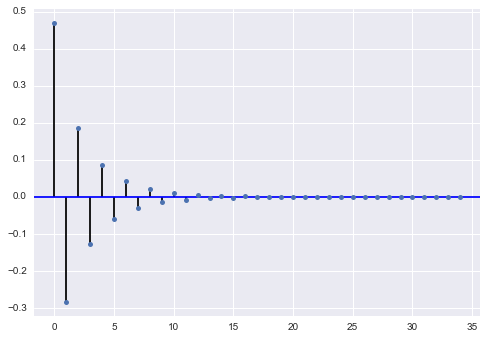

In [15]:
ma1pacf = ma_pacf(ma1params, 36)
plot_theoretical_acf(ma1pacf)

## Models with Both AR and MA Terms

A model that involves both AR and MA terms might be written $$y_t=\mu+\sum_{i=1}^p\beta_iy_{t-i}+\epsilon_t+\sum_{j=1}^q\theta_q\epsilon_{t-q}$$ where $\beta_1,\ldots,\beta_p$ are the autoregressive parameters to be estimated, $\theta_1,\ldots,\theta_q$ are the moving average parameters to be estimated, and $\epsilon_1,\ldots,\epsilon_t$ are a series of unknown random errors (or residuals) that are assumed to follow a normal distribution.  This is also referred to as an $\mbox{ARMA}(p,q)$ model.

In [16]:
from statsmodels import datasets
from statsmodels.tsa.arima_model import ARMA

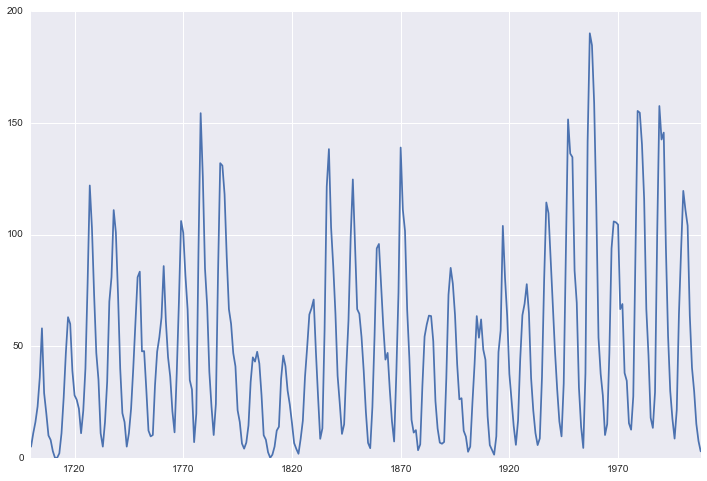

In [17]:
dta = datasets.sunspots.load_pandas()
sunspots = dta.data.SUNACTIVITY
sunspots.index = dta.endog.index.map(pd.tseries.period.Period)
sunspots.plot(figsize=(12,8));

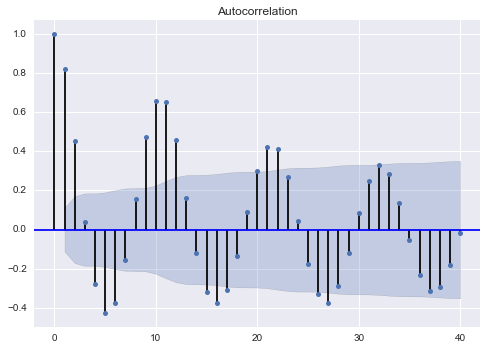

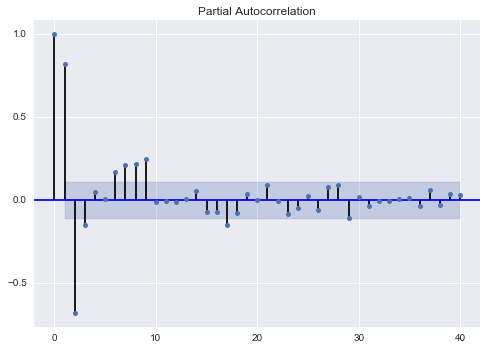

In [18]:
plot_acf(sunspots, lags=40);
plot_pacf(sunspots, lags=40);

In [19]:
arma_mod33 = ARMA(sunspots, (3,3)).fit()
print(arma_mod33.params)

const                48.864992
ar.L1.SUNACTIVITY     2.546062
ar.L2.SUNACTIVITY    -2.441384
ar.L3.SUNACTIVITY     0.869940
ma.L1.SUNACTIVITY    -1.411673
ma.L2.SUNACTIVITY     0.431191
ma.L3.SUNACTIVITY     0.159175
dtype: float64


In [20]:
arma_mod33.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 2605.5624 
Dependent Variable: SUNACTIVITY      Log-Likelihood:      -1279.8   
Date:               2016-10-04 11:01 Scale:               1.0000    
No. Observations:   309              Method:              css-mle   
Df Model:           7                Sample:              12-31-1700
Df Residuals:       302                                   12-31-2008
Converged:          1.0000           S.D. of innovations: 15.131    
AIC:                2575.6956        HQIC:                2587.636  
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const               48.8650   5.8838   8.3050 0.0000 37.3329 60.3971
ar.L1.SUNACTIVITY    2.5461   0.0336  75.7920 0.0000  2.4802  2.6119
ar.L2.SUNACTIVITY   -2.4414   0.0560 -43.5734 0.0000 -2.5512 -2.3316
ar.L3.SUNACTIVITY    0.8699   0.0314  27.6975 0.0000  0.8084  0.9315
ma.L1.SUNACTIVITY   -1.4117   0.0613 -23.0324 0.0000 -1.5318 -1.2915
ma.L2.SUNACTIVITY    0.4312   0.0932   4.6251 0.0000  0.2485  0.6139
ma.L3.SUNACTIVITY    0.1592   0.0553   2.8766 0.0043  0.0507  0.2676
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.8600            -0.5644           1.0287            -0.0924
AR.2            0.8600             0.5644           1.0287             0.0924
AR.3            1.0863            -0.0000           1.0863            -0.0000
MA.1            1.0553            -0.4357           1.1417            -0.0623
MA.2            1.0553             0.4357           1.1417             0.0623
MA.3           -4.8195            -0.0000           4.8195            -0.5000
====================================================================

"""